In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('/content/airlines_flights_data.csv')

In [3]:
df.head(2)

,index,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1.0,5953.0
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1.0,5953.0


In [4]:
df.dtypes

,0
index,int64
airline,object
flight,object
source_city,object
departure_time,object
stops,object
arrival_time,object
destination_city,object
class,object
duration,float64


In [5]:
df['airline'].value_counts()

,count
airline,
Vistara,18728
Air_India,15423
Indigo,12271
GO_FIRST,9192
AirAsia,5811
SpiceJet,3535


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

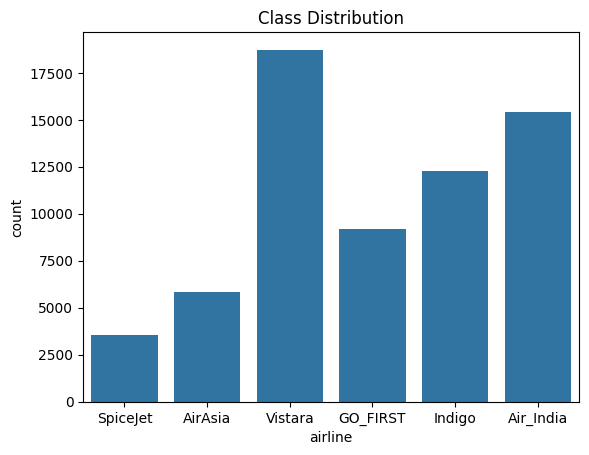

In [7]:
sns.countplot(x='airline',data=df)
plt.title('Class Distribution')
plt.show()

In [8]:
percentages = df['airline'].value_counts(normalize=True)*100
print(percentages)

airline
Vistara      28.830049
Air_India    23.742303
Indigo       18.890086
GO_FIRST     14.150246
AirAsia       8.945505
SpiceJet      5.441810
Name: proportion, dtype: float64


In [9]:
# pip install imbalanced-learn

In [10]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

lb=LabelEncoder()
df['airline'] = lb.fit_transform(df[['airline']])
df['flight'] = lb.fit_transform(df[['flight']])
df['source_city'] = lb.fit_transform(df[['source_city']])
df['departure_time'] = lb.fit_transform(df[['departure_time']])
df['stops'] = lb.fit_transform(df[['stops']])
df['arrival_time'] = lb.fit_transform(df[['arrival_time']])
df['destination_city'] = lb.fit_transform(df[['destination_city']])
df['class'] = lb.fit_transform(df[['class']])

X=df.drop(columns = ['airline'])
y=df['airline']

# Split into train-test (always apply SMOTE on training data only)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

In [11]:
from collections import Counter

print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))


Before SMOTE: Counter({5: 14046, 1: 11568, 3: 9203, 2: 6894, 0: 4358, 4: 2651})
After SMOTE: Counter({2: 14046, 3: 14046, 5: 14046, 1: 14046, 4: 14046, 0: 14046})


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)



In [13]:
random_search.fit(X_train_resampled, y_train_resampled)

print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 30, 'bootstrap': True}


In [14]:
best_model = random_search.best_estimator_

from sklearn.metrics import accuracy_score, classification_report
y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Test Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1453
           1       1.00      1.00      1.00      3855
           2       1.00      1.00      1.00      2298
           3       1.00      1.00      1.00      3068
           4       1.00      1.00      1.00       884
           5       1.00      1.00      1.00      4682

    accuracy                           1.00     16240
   macro avg       1.00      1.00      1.00     16240
weighted avg       1.00      1.00      1.00     16240

